In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

### Funciones

In [55]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def xavier_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size) * np.sqrt(2 / (input_size + output_size))

def adam_optimizer(parameters, gradients, mt, vt, beta1=0.9, beta2=0.999, learning_rate=0.0001, epsilon=1e-8, t=1):
    mt = beta1 * mt + (1 - beta1) * gradients
    vt = beta2 * vt + (1 - beta2) * (gradients ** 2)
    mt_hat = mt / (1 - beta1 ** t)
    vt_hat = vt / (1 - beta2 ** t)
    parameters -= learning_rate * mt_hat / (np.sqrt(vt_hat) + epsilon)
    return parameters, mt, vt

### Cargamos los datos

In [56]:
data = pd.read_csv('C:\\Users\\Usuario\\Desktop\\UNIVERSIDAD\\TERCER AÑO\\PRIMER CUATRI\\OH\\Red\\red2\\Fashion\\fashion-mnist_train.csv')
X_train = data.drop('label', axis=1)  # Features
y_train = data['label']  # Labels

data_test = pd.read_csv('C:\\Users\\Usuario\\Desktop\\UNIVERSIDAD\\TERCER AÑO\\PRIMER CUATRI\\OH\\Red\\red2\\Fashion\\fashion-mnist_test.csv')
X_test = data_test.drop('label', axis=1)
y_test = data_test['label']

# Normalización de datos
X_train = X_train / 255.0
X_test = X_test / 255.0

### Estructura de la red

In [57]:
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = 10

### Inicialización de pesos con Xavier

In [58]:
weights_input_hidden1 = xavier_initialization(input_size, hidden_size1)
bias_hidden1 = np.zeros((1, hidden_size1))
weights_hidden1_hidden2 = xavier_initialization(hidden_size1, hidden_size2)
bias_hidden2 = np.zeros((1, hidden_size2))
weights_hidden2_hidden3 = xavier_initialization(hidden_size2, hidden_size3)
bias_hidden3 = np.zeros((1, hidden_size3))
weights_hidden3_output = xavier_initialization(hidden_size3, output_size)
bias_output = np.zeros((1, output_size))

### Inicializamo los momentos para Adam

In [59]:
# Inicializa los momentos de primer y segundo orden para Adam
mt_hidden_output = np.zeros_like(weights_hidden3_output)
vt_hidden_output = np.zeros_like(weights_hidden3_output)
mt_hidden2_hidden3 = np.zeros_like(weights_hidden2_hidden3)
vt_hidden2_hidden3 = np.zeros_like(weights_hidden2_hidden3)
mt_hidden1_hidden2 = np.zeros_like(weights_hidden1_hidden2)
vt_hidden1_hidden2 = np.zeros_like(weights_hidden1_hidden2)
mt_input_hidden1 = np.zeros_like(weights_input_hidden1)
vt_input_hidden1 = np.zeros_like(weights_input_hidden1)

In [60]:
# Define la tasa de aprendizaje
learning_rate = 0.0001  

# Define el número de épocas de entrenamiento
epochs = 2000


loss_history = []
accuracy_history = []

### Entrenamiento

In [61]:
for epoch in range(epochs):
    hidden_layer_input1 = np.dot(X_train, weights_input_hidden1) + bias_hidden1
    hidden_layer_output1 = relu(hidden_layer_input1)

    hidden_layer_input2 = np.dot(hidden_layer_output1, weights_hidden1_hidden2) + bias_hidden2
    hidden_layer_output2 = relu(hidden_layer_input2)

    hidden_layer_input3 = np.dot(hidden_layer_output2, weights_hidden2_hidden3) + bias_hidden3
    hidden_layer_output3 = relu(hidden_layer_input3)

    output_layer_input = np.dot(hidden_layer_output3, weights_hidden3_output) + bias_output
    exp_scores = np.exp(output_layer_input)
    output_layer_output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calcular la pérdida
    loss = -np.log(output_layer_output[range(len(y_train)), y_train]).mean()
    loss_history.append(loss)


    # Backward pass
    error = output_layer_output
    error[range(len(y_train)), y_train] -= 1

    d_output = error
    error_hidden3 = d_output.dot(weights_hidden3_output.T)
    d_hidden3 = error_hidden3 * relu_derivative(hidden_layer_output3)

    error_hidden2 = d_hidden3.dot(weights_hidden2_hidden3.T)
    d_hidden2 = error_hidden2 * relu_derivative(hidden_layer_output2)

    error_hidden1 = d_hidden2.dot(weights_hidden1_hidden2.T)
    d_hidden1 = error_hidden1 * relu_derivative(hidden_layer_output1)

    # Actualiza los pesos utilizando el algoritmo Adam
    weights_hidden3_output, mt_hidden_output, vt_hidden_output = adam_optimizer(
        weights_hidden3_output, hidden_layer_output3.T.dot(d_output) * learning_rate,
        mt_hidden_output, vt_hidden_output, t=epoch+1
    )

    bias_output -= np.sum(d_output, axis=0, keepdims=True) * learning_rate

    weights_hidden2_hidden3, mt_hidden2_hidden3, vt_hidden2_hidden3 = adam_optimizer(
        weights_hidden2_hidden3, hidden_layer_output2.T.dot(d_hidden3) * learning_rate,
        mt_hidden2_hidden3, vt_hidden2_hidden3, t=epoch+1
    )

    bias_hidden3 -= np.sum(d_hidden3, axis=0, keepdims=True) * learning_rate

    weights_hidden1_hidden2, mt_hidden1_hidden2, vt_hidden1_hidden2 = adam_optimizer(
        weights_hidden1_hidden2, hidden_layer_output1.T.dot(d_hidden2) * learning_rate,
        mt_hidden1_hidden2, vt_hidden1_hidden2, t=epoch+1
    )

    bias_hidden2 -= np.sum(d_hidden2, axis=0, keepdims=True) * learning_rate

    weights_input_hidden1, mt_input_hidden1, vt_input_hidden1 = adam_optimizer(
        weights_input_hidden1, X_train.T.dot(d_hidden1) * learning_rate,
        mt_input_hidden1, vt_input_hidden1, t=epoch+1
    )

    bias_hidden1 -= np.sum(d_hidden1, axis=0, keepdims=True) * learning_rate


    # Realizar predicciones
    hidden_layer_input1 = np.dot(X_test, weights_input_hidden1) + bias_hidden1
    hidden_layer_output1 = relu(hidden_layer_input1)

    hidden_layer_input2 = np.dot(hidden_layer_output1, weights_hidden1_hidden2) + bias_hidden2
    hidden_layer_output2 = relu(hidden_layer_input2)

    hidden_layer_input3 = np.dot(hidden_layer_output2, weights_hidden2_hidden3) + bias_hidden3
    hidden_layer_output3 = relu(hidden_layer_input3)

    output_layer_input = np.dot(hidden_layer_output3, weights_hidden3_output) + bias_output
    exp_scores = np.exp(output_layer_input)
    output_layer_output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    predictions = np.argmax(output_layer_output, axis=1)
    accuracy = np.mean(predictions == y_test)


    accuracy_history.append(accuracy)

### Matriz de confusión

Matriz de Confusión:
[[809   6  15  55   0   1 101   0  11   2]
 [  4 960   5  22   2   0   6   0   0   1]
 [ 17   2 746  13 102   0 110   0  10   0]
 [ 32  19  10 883  26   0  27   0   3   0]
 [  1   1  72  35 776   0 110   0   5   0]
 [  2   0   0   1   0 911   1  55   6  24]
 [156   3  81  50  60   1 636   0  13   0]
 [  0   0   0   0   0  30   0 917   0  53]
 [  3   1   4   2   4   5  25   4 951   1]
 [  0   0   0   0   0  16   0  48   0 936]]


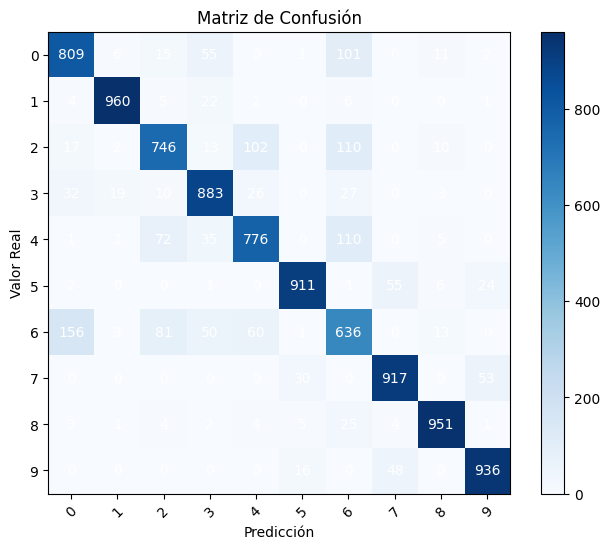

In [62]:
# Calcular la matriz de confusión
predictions = predictions.ravel()

confusion = confusion_matrix(y_test, predictions)

print("Matriz de Confusión:")
print(confusion)


# Crea una figura y un eje
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Configura etiquetas de los ejes
tick_marks = range(10)  # El número de clases en tu caso
plt.xticks(tick_marks, range(10), rotation=45)
plt.yticks(tick_marks, range(10))

# Añade valores a las celdas
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, str(confusion[i, j]), ha='center', va='center', color='white')

# Configura etiquetas de los ejes y el título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Muestra la gráfica
plt.show()

### Grafico de Perdida y Accuracy

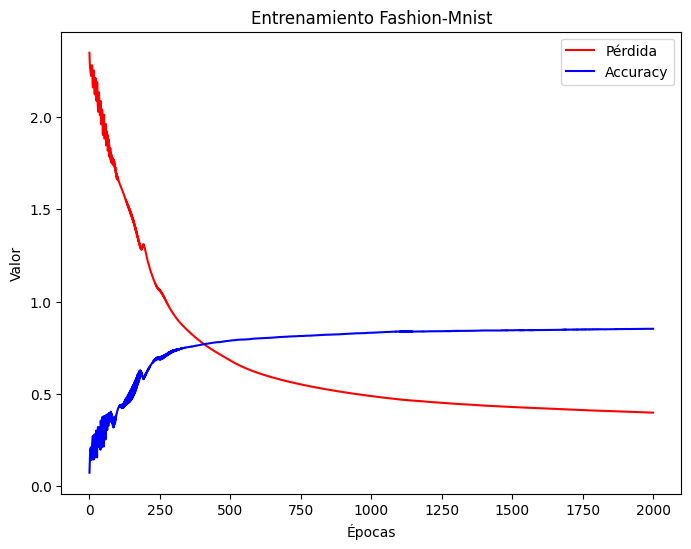

In [63]:
# Crear una figura y un solo gráfico
plt.figure(figsize=(8, 6))

# Gráfica de pérdida
plt.plot(range(1, epochs + 1), loss_history, label='Pérdida', color='red')
plt.plot(range(1, epochs + 1), accuracy_history, label='Accuracy', color='blue')

# Título y etiquetas
plt.title('Entrenamiento Fashion-Mnist')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.legend(loc="upper right")

# Mostrar la figura
plt.show()

